In [63]:
import numpy as np
import scipy as sp
from numpy import random
from random import choices
import matplotlib.pyplot as plt
import levy
# import plotly.express as px

Replicating the experiment conducted by Daw et.al. (2006): https://www.nature.com/articles/nature04766#Sec3

In [323]:
class Bandits:
    def __init__(self,total_time):
        self.options = 4            # Number of options
        self.sigma = 4              # Variance of sampled payoff from option
        self.decay = 0.9836         # Decay constant of expected payoff RW
        self.decay_centre = 50      # Decay centre of expected payoff RW
        self.sigma_noise = 2.8      # Variance of expected payoff RW
        self.time = total_time      # Total simulation time

    def sample(self,mu):
        # Sample from input mean and constant variance
        return random.normal(mu,self.sigma)
    
    def genMeans(self,starting_var):
        # Generate the mean payoff according to a decaying Gaussian random walk (what is decaying?)
        noise = random.normal(0,self.sigma_noise,(self.options,self.time))   # Preallocating Gaussian noise for payoff diffusion
        payoff0 = np.round(random.normal(50,starting_var,(self.options,1)))            # Defining expected payoffs for step 1
        payoff = np.zeros([self.options,self.time])                          # Preallocating payoff walker
        payoff[:,0] = np.transpose(payoff0)
        for t in range(1,self.time):        # Loop over time and generate expected payoff RW
            payoff[:,t] = self.decay*payoff[:,t-1] + (1-self.decay) * self.decay_centre + noise[:,t]
        return payoff

    def findRegret(self,payoff,result):
        optimal_scores = np.zeros(self.time)
        for t in range(self.time):
            chosen = np.argmax(payoff[:,t])
            # optimal_scores[t] = self.sample(payoff[chosen,t])
            optimal_scores[t] = payoff[chosen,t]
        regret = 1 - result/sum(optimal_scores)
        return regret, optimal_scores

    def exploit(self,payoff,trials):
        scores = np.zeros([trials,self.time])                               # Initialise score history
        scores[:,range(4)] = [self.sample(payoff[range(4),0]) for _ in range(trials)]     # Sample from each option once
        chosen = np.argmax(scores,1)
        for t in range(4,self.time):
            scores[:,t] = self.sample(payoff[chosen,t])
        return np.sum(scores,1)

    def softmax(self,payoff,temp,trials):
        scores = np.zeros([trials,self.time])
        history = {idx: np.zeros([trials,self.time]) for idx in range(4)}
        history_choices = np.zeros([trials,time])
        for option in history:
            scores[:,option] = self.sample(np.zeros(trials) + payoff[option,0])
            history[option][:,option] = scores[:,option]
            history_choices[:,idx] = np.zeros(trials) + idx

        for t in range(4,time):
            expected_rewards = np.transpose([np.sum(history[option],1)/np.count_nonzero(history[option],1) for option in history])/temp
            weights = np.exp(expected_rewards) / np.sum(np.exp(expected_rewards),1).reshape([trials,1])
            chosen = (np.random.rand(len(weights),1) < weights.cumsum(axis=1)).argmax(axis=1)      # Selecting from probabilities
            scores[:,t] = self.sample(payoff[chosen,t])
            for i,c in enumerate(chosen):
                history[c][i,t] = scores[i,t]
            history_choices[:,t] = chosen
        return np.sum(scores,1),history_choices


In [316]:
trials = 100
time = 300
temp = 5        # temperature == exploration factor (higher = more exploration)
scores = np.zeros([trials,time])
history = {idx: np.zeros([trials,time]) for idx in range(4)}
history_choices = np.zeros([trials,time])
for idx in history:
    scores[:,idx] = simu.sample(np.zeros(trials) + payoffs[idx,0])
    history[idx][:,idx] = scores[:,idx]
    history_choices[:,idx] = np.zeros(trials) + idx

for t in range(4,time):
    expected_rewards = np.transpose([np.sum(history[option],1)/np.count_nonzero(history[option],1) for option in history])/temp
    weights = np.exp(expected_rewards) / np.sum(np.exp(expected_rewards),1).reshape([trials,1])
    chosen = (np.random.rand(len(weights),1) < weights.cumsum(axis=1)).argmax(axis=1)      # Selecting from probabilities
    scores[:,t] = simu.sample(payoffs[chosen,t])
    for i,c in enumerate(chosen):
        history[c][i,t] = scores[i,t]
    history_choices[:,t] = chosen



Number of times sampled:  blue: 0.18, green: 0.08, red: 0.64, orange: 0.1


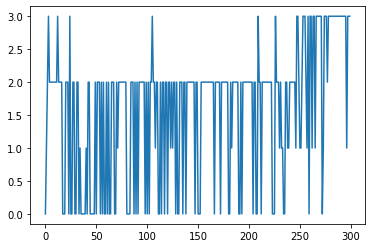

In [339]:
plt.plot(history_choices[0,:])
unique, counts = np.unique(history_choices, return_counts = True)
print('Number of times sampled: ',(', ').join([colors[i] +': '+str(round(counts[i]/sum(counts),2)) for i in range(4)]))

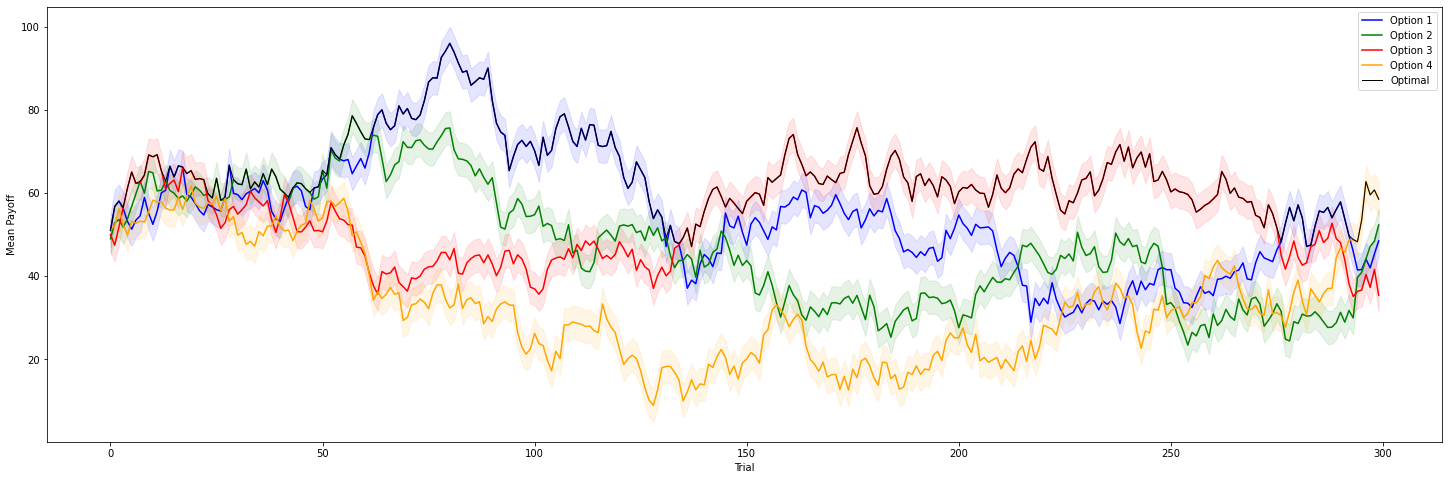

In [345]:
total_time = 300
simu = Bandits(total_time)
payoffs = simu.genMeans(1)
[_, optimal_scores] = simu.findRegret(payoffs,0)


# Plotting payoff distribution with 1 SD error range + optimal picking overlaid
fig,ax = plt.subplots(figsize=(25,8))
colors = ['blue','green','red','orange']
for i in range(len(payoffs)):
    plt.plot(range(total_time),payoffs[i,:], color=colors[i], label='Option '+str(i+1))                
    plt.fill_between(range(total_time),payoffs[i,:]-simu.sigma, payoffs[i,:]+simu.sigma,color=colors[i],alpha=0.1)
plt.plot(range(total_time),optimal_scores,linewidth=1, color='black', label='Optimal')        # Plotting optimal score

plt.xlabel('Trial')
plt.ylabel('Mean Payoff')
plt.legend()
plt.show()

In [346]:
exploit_reward = simu.exploit(payoffs,10000)
[exploit_regret, _] = simu.findRegret(payoffs,exploit_reward)
print('Pure exploitation Mean Regret: %s'% np.mean(exploit_regret),', Std: %s'% np.std(exploit_regret))

softmax_reward, softmax_choices = simu.softmax(payoffs,10,1000)
[softmax_regret, _] = simu.findRegret(payoffs,softmax_reward)
print('Pure exploitation Mean Regret: %s'% np.mean(softmax_regret),', Std: %s'% np.std(softmax_regret))
unique, counts = np.unique(softmax_choices, return_counts = True)
print('Number of times sampled: ',(', ').join([colors[i] +': '+str(round(counts[i]/sum(counts),2)) for i in range(4)]))

Pure exploitation Mean Regret: 0.27446349192526104 , Std: 0.1510269506287367
Pure exploitation Mean Regret: 0.18585503758898958 , Std: 0.013489135368789701
Number of times sampled:  blue: 0.42, green: 0.25, red: 0.24, orange: 0.09
